In [25]:
# importing essential libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers
from tensorflow import data as tf_data

In [26]:
# getting data from the dataset of 'oxford_iiit_pet:3.2.0'
# This dataset contains 37 pet breeds
# dividing them to train, validation and test datasets
train_dataset, validation_dataset, test_dataset = tfds.load(
    'oxford_iiit_pet:3.2.0',
    split=["train[0%:80%]", "train[80%:100%]", "test"],
    shuffle_files=True,
    as_supervised=True
)

In [27]:
# checking the number of data samples in each dataset
print(f"Number of training samples: {train_dataset.cardinality()}")
print(f"Number of validation samples: {validation_dataset.cardinality()}")
print(f"Number of test samples: {test_dataset.cardinality()}")

Number of training samples: 2944
Number of validation samples: 736
Number of test samples: 3669


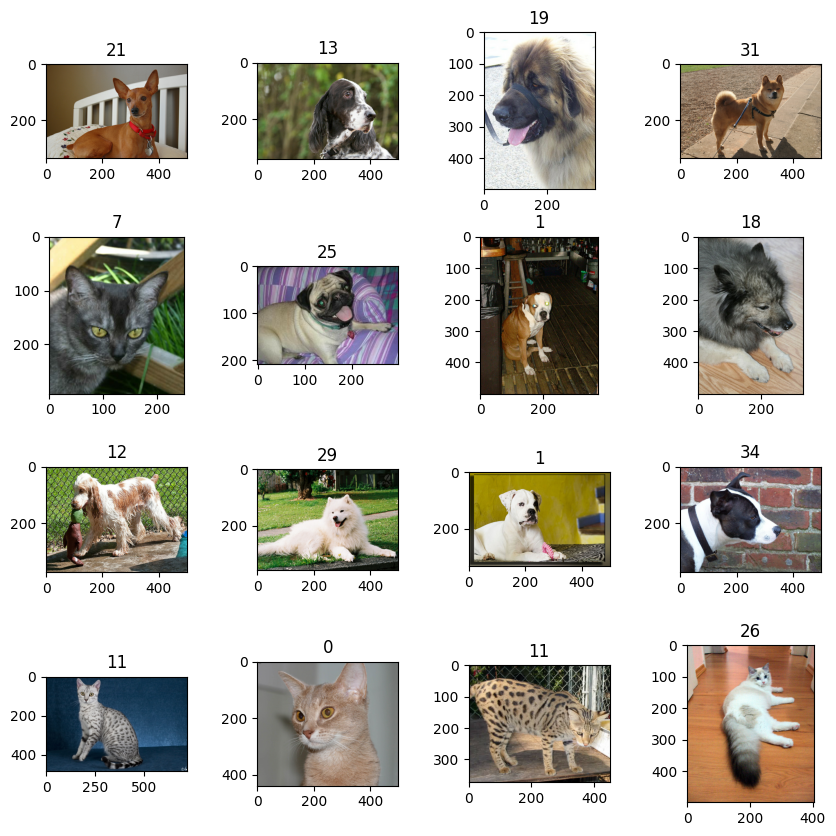

In [28]:
# checking the first 16 images in the train dataset
# integer above the image shows the pet breed it belong to
# The images are not in a same size
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("on")
plt.subplots_adjust(wspace=0.5, hspace=0.3)
# Because we have shuffled the dataset, .take method randomly choses the 16 images.

In [29]:
def process_image(image, label):
    image = tf.image.resize(image, (224, 224)) # Resizing to the relevant size
    image = tf.keras.applications.resnet.preprocess_input(tf.cast(image, tf.float32)) # Normalizing
    return image, label

train_dataset = train_dataset.map(process_image)
validation_dataset = validation_dataset.map(process_image)
test_dataset = test_dataset.map(process_image)


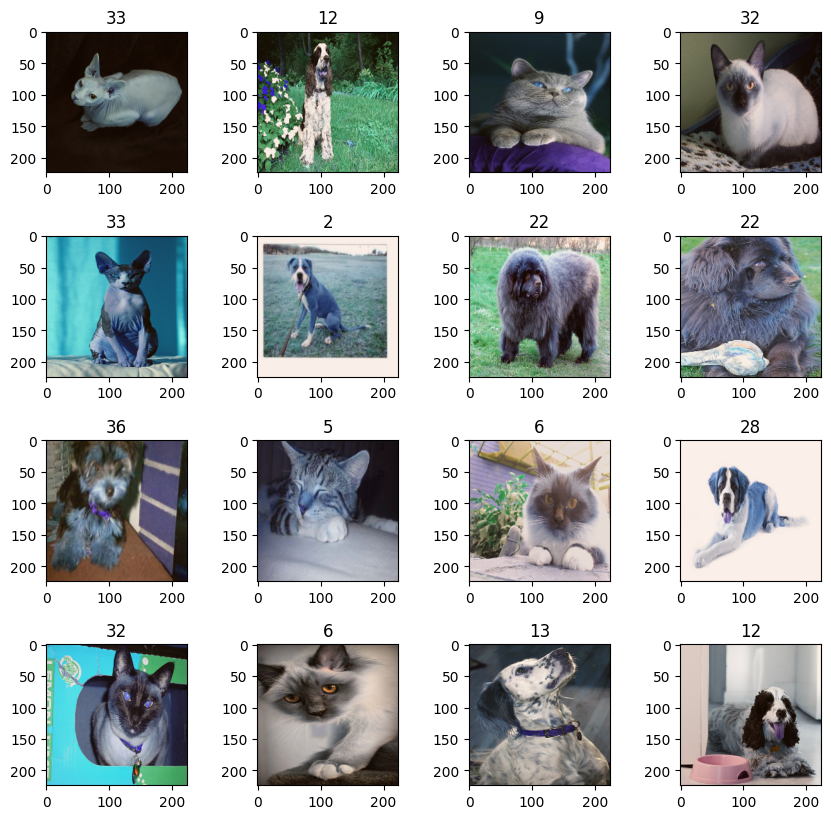

In [44]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow((image + 125)/280)
    plt.title(int(label))
    plt.axis("on")
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

In [45]:
# introducing flippings and small rotations to the dataset
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

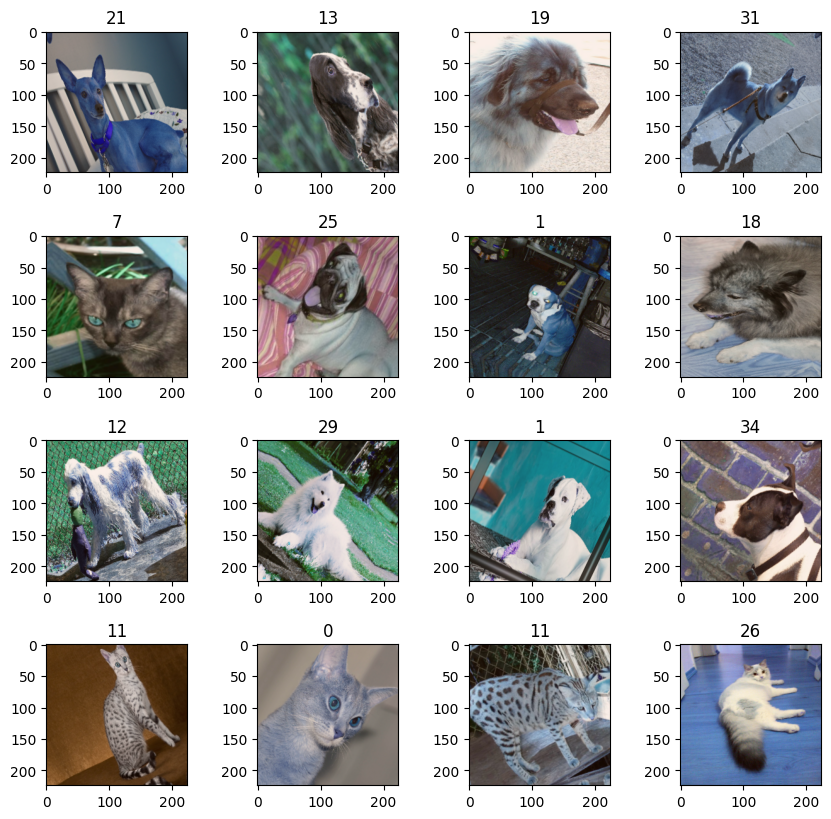

In [46]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow((image + 125)/280)
    plt.title(int(label))
    plt.axis("on")
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

In [47]:
batch_size = 32

train_dataset = train_dataset.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_dataset = test_dataset.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

In [48]:
# Loading weights of pre-trained ResNet50 model on ImageNet
# Removing the ImageNet classifier at the top of the model
base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(224,224,3),
                                                     pooling=max)

# Freeze the base_model and creating a new layer on top of the model
base_model.trainable = False
weight_decay = 0.01
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here
# Regularize is done dropout
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(37, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 resnet50 (Functional)       (None, 7, 7, 2048)        2358771   N          
                                                       2                    
                                                                            
 global_average_pooling2d_2  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dense_2 (Dense)             (None, 37)                75813     Y          
                                                                            
Total params: 23663525 (90.27 MB)
Trainable params: 75813 (

In [49]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005,weight_decay=weight_decay),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, verbose=1,mode="min",restore_best_weights=True)
model.fit(train_dataset, epochs=5, callbacks=[callback], validation_data=validation_dataset)

Epoch 1/5


c:\Users\senuruk\anaconda3\envs\myenv\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 275s 3s/step - loss: 2.7980 - accuracy: 0.4671 - val_loss: 1.5663 - val_accuracy: 0.8043
Epoch 2/5
92/92 [==============================] - 270s 3s/step - loss: 1.3359 - accuracy: 0.8536 - val_loss: 1.2186 - val_accuracy: 0.8614
Epoch 3/5
92/92 [==============================] - 247s 3s/step - loss: 1.0364 - accuracy: 0.9202 - val_loss: 1.0698 - val_accuracy: 0.8804
Epoch 4/5
92/92 [==============================] - 248s 3s/step - loss: 0.8700 - accuracy: 0.9501 - val_loss: 0.9650 - val_accuracy: 0.8886
Epoch 5/5
92/92 [==============================] - 322s 4s/step - loss: 0.7517 - accuracy: 0.9711 - val_loss: 0.8811 - val_accuracy: 0.8954


In [50]:
print("Test dataset evaluation")
model.evaluate(test_dataset)

Test dataset evaluation
115/115 [==============================] - 272s 2s/step - loss: 0.9774 - accuracy: 0.8569


[0.9773732423782349, 0.8569092154502869]

In [51]:
base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling=max)
base_model.trainable = True

In [52]:
weight_decay = 0.001
model_new = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(37, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
])

model_new.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 resnet50 (Functional)       (None, 7, 7, 2048)        2358771   Y          
                                                       2                    
                                                                            
 global_average_pooling2d_3  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 2048)              0         Y          
                                                                            
 dense_3 (Dense)             (None, 37)                75813     Y          
                                                                            
Total params: 23663525 (90.27 MB)
Trainable params: 2361

In [53]:

# Compile the model with a lower learning rate to fine-tune the unfrozen layers
model_new.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005,weight_decay=weight_decay),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1,mode="min",restore_best_weights=True)
# Train the model with the same callbacks and epochs
model_new.fit(train_dataset, epochs=5, callbacks=[callback], validation_data=validation_dataset)

Epoch 1/5


c:\Users\senuruk\anaconda3\envs\myenv\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 1483s 15s/step - loss: 2.1263 - accuracy: 0.4745 - val_loss: 0.6118 - val_accuracy: 0.8302
Epoch 2/5
92/92 [==============================] - 1384s 15s/step - loss: 0.3690 - accuracy: 0.9453 - val_loss: 0.4983 - val_accuracy: 0.8628
Epoch 3/5
92/92 [==============================] - 1260s 14s/step - loss: 0.1394 - accuracy: 0.9963 - val_loss: 0.4635 - val_accuracy: 0.8832
Epoch 4/5
92/92 [==============================] - 1266s 13s/step - loss: 0.0981 - accuracy: 1.0000 - val_loss: 0.4513 - val_accuracy: 0.8845
Epoch 5/5
92/92 [==============================] - 1316s 14s/step - loss: 0.0859 - accuracy: 1.0000 - val_loss: 0.4480 - val_accuracy: 0.8886


In [54]:
print("Test dataset evaluation")
model_new.evaluate(test_dataset)

Test dataset evaluation
115/115 [==============================] - 477s 4s/step - loss: 0.4950 - accuracy: 0.8795


[0.4950472116470337, 0.87953120470047]